# Первая сессия

## Импорт библиотек

In [150]:
from bs4 import BeautifulSoup
import pandas as pd  
import os
import numpy as np

## Парсер HTML страниц с хабра

In [151]:
# Получаем текущую рабочую директорию
current_directory = os.getcwd()

# Имя подпапки, которую вы ищете
folder_name = "data"

# Создаем путь к целевой папке
folder_path = os.path.join(current_directory, folder_name)

# Список для хранения словарей данных
data_list = []

# Проходим по всем файлам в папке
for filename in os.listdir(folder_path):
    # Проверяем, является ли файл HTML-файлом
    if filename.endswith('.html'):
        file_path = os.path.join(folder_path, filename)

        # Читаем содержимое файла
        with open(file_path, 'r', encoding='utf-8') as file:
            file_content = file.read()

        # Используем BeautifulSoup для парсинга
        soup = BeautifulSoup(file_content, 'html.parser')

        # Извлечение данных
        rating = soup.find('span', {'class': 'tm-votes-lever__score-counter tm-votes-lever__score-counter tm-votes-lever__score-counter_rating'})
        company = soup.find('a', {'class': 'tm-company-card__name'})
        titles = soup.find_all('a', {'class': 'tm-title__link'})
        articles = soup.find_all('div', {'class': 'article-formatted-body'})
        votes = soup.find_all('span', {'class': 'tm-votes-meter__value'})
        views = soup.find_all('span', {'class': 'tm-icon-counter__value'})
        comments = soup.find_all('span', {'class': 'bookmarks-button__counter'})
        
        # Извлечение текста из тегов и очистка от лишних пробелов
        rating_text = rating.get_text().strip()
        company_text = company.get_text().strip()
        titles_text = [link.get_text().strip() for link in titles]
        articles_text = [link.get_text().strip() for link in articles]
        votes_text = [link.get_text().strip() for link in votes]
        views_text = [link.get_text().strip() for link in views]
        comments_text = [link.get_text().strip() for link in comments]

        # Повторение значений рейтинга и названия компании для каждой статьи
        rating_values = [rating_text] * len(votes_text)
        company_values = [company_text] * len(votes_text)

        # Создание словаря с извлеченными данными
        elements_dict = {
            'rating': rating_values,
            'company': company_values,
            'titles': titles_text,
            'articles': articles_text,
            'votes': votes_text,
            'views': views_text,
            'comments': comments_text,
        }

        # Добавление словаря в список данных
        data_list.append(elements_dict)

# Создание DataFrame из списка данных и преобразуем столбцы, чтобы каждая строка соответствовала одной статье
df = pd.DataFrame(data_list)
df = df.apply(lambda col: col.explode()).reset_index(drop=True)

# Вывод DataFrame
df

,rating,company,titles,articles,votes,views,comments
0,601.87,Альфа-Банк,"Место крипты в реальном мире, или Куда придёт ...","Криптовалюты пока не захватили мир, потому что...",-6,702,3
1,601.87,Альфа-Банк,Как я в 22 года получил «лычку» Senior,"Привет, читатель! Хотел поделиться историей о ...",-16,16K,25
2,601.87,Альфа-Банк,Практическая магия Istio при построении архите...,Под Новый Год мы с женой пересматриваем одну п...,+19,5.7K,74
3,601.87,Альфа-Банк,Зачем вам эмоциоанльный дизайн,Привет! Я Лёша. Cейчас руковожу командами эмоц...,+11,1.7K,12
4,601.87,Альфа-Банк,"Что я делал, когда развивал свою карьеру бэкен...","Меня зовут Константин, последние 6 лет я профе...",+25,14K,82
...,...,...,...,...,...,...,...
215,415.77,Ozon Tech,Создание карты зависимостей: как увидеть систе...,"Хабр, привет! Я Саша, Product Manager в Ozon. ...",+17,7.6K,60
216,415.77,Ozon Tech,Приглашаем на Ozon Tech Community QA Meetup,"Привет, меня зовут Дима, я руководитель группы...",+5,935,2
217,415.77,Ozon Tech,Приглашаем на Ozon Tech Community Go Meetup,"Всем привет! Я – Влад, руководитель группы пои...",+7,1.2K,11
218,415.77,Ozon Tech,"Видеоредактор, работа с видео и зачем там Canvas",Современные устройства и браузеры развиваются ...,+67,3.3K,15


## Обработка данных

In [152]:
# Вывод информации о данных до обработки
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220 entries, 0 to 219
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   rating    220 non-null    object
 1   company   220 non-null    object
 2   titles    220 non-null    object
 3   articles  220 non-null    object
 4   votes     220 non-null    object
 5   views     220 non-null    object
 6   comments  220 non-null    object
dtypes: object(7)
memory usage: 12.2+ KB


#### Приведение столбца views в числовые значения, измененение типов данных для rating, comments, votes

In [153]:
# Функция для конвертации значения 'views' в числовой формат
def convert_to_int(value):
    if 'K' in value:
        return int(float(value.replace('K', '')) * 1000)
    else:
        return int(value)

# Конвертация значений 'views'
df['views'] = df['views'].apply(convert_to_int)

# Конвертация значений 'views' и 'comments' в числовой формат
df[['views', 'comments']] = df[['views', 'comments']].astype(int)

# Конвертация значений 'rating' в числовой формат
df[['rating']] = df[['rating']].astype(float)

# Конвертация значений 'votes' в числовой формат
df['votes'] = df['votes'].apply(lambda x: eval(x.replace('+', '')))
df['votes'] = pd.to_numeric(df['votes'])

# Вывод DataFrame
df


,rating,company,titles,articles,votes,views,comments
0,601.87,Альфа-Банк,"Место крипты в реальном мире, или Куда придёт ...","Криптовалюты пока не захватили мир, потому что...",-6,702,3
1,601.87,Альфа-Банк,Как я в 22 года получил «лычку» Senior,"Привет, читатель! Хотел поделиться историей о ...",-16,16000,25
2,601.87,Альфа-Банк,Практическая магия Istio при построении архите...,Под Новый Год мы с женой пересматриваем одну п...,19,5700,74
3,601.87,Альфа-Банк,Зачем вам эмоциоанльный дизайн,Привет! Я Лёша. Cейчас руковожу командами эмоц...,11,1700,12
4,601.87,Альфа-Банк,"Что я делал, когда развивал свою карьеру бэкен...","Меня зовут Константин, последние 6 лет я профе...",25,14000,82
...,...,...,...,...,...,...,...
215,415.77,Ozon Tech,Создание карты зависимостей: как увидеть систе...,"Хабр, привет! Я Саша, Product Manager в Ozon. ...",17,7600,60
216,415.77,Ozon Tech,Приглашаем на Ozon Tech Community QA Meetup,"Привет, меня зовут Дима, я руководитель группы...",5,935,2
217,415.77,Ozon Tech,Приглашаем на Ozon Tech Community Go Meetup,"Всем привет! Я – Влад, руководитель группы пои...",7,1200,11
218,415.77,Ozon Tech,"Видеоредактор, работа с видео и зачем там Canvas",Современные устройства и браузеры развиваются ...,67,3300,15


#### Проверка и обработка на наличие дублирующихся записей
Дублирующиеся записи могут внести шум в анализ данных.

In [154]:
# Поиск дубликатов
duplicate_rows = df[df.duplicated()]

# Удаление дубликатов
df = df.drop_duplicates()
print(f"Количество дублирующихся записей: {len(duplicate_rows)}")

Количество дублирующихся записей: 0


#### Проверка и обработка наличия пустых записей
Пустые записи могут повлиять на анализ и моделирование.

In [155]:
# Поиск пустых записей
missing_values = df.isnull().sum()

# Обработка пустых записей
df = df.dropna()
print(f"Количество пустых записей в каждом столбце:\n{missing_values}")

Количество пустых записей в каждом столбце:
rating      0
company     0
titles      0
articles    0
votes       0
views       0
comments    0
dtype: int64


#### Поиск и обработка выбросов
Выбросы могут исказить статистики.

Межквартильный размах используется для выявления выбросов, поскольку он предоставляет статистический интервал, охватывающий основную долю данных в распределении. Этот метод основан на квартилях данных и предоставляет более робастную оценку разброса, устойчивую к наличию экстремальных значений, что делает его эффективным инструментом для выявления потенциальных аномалий в данных.

In [156]:
# Выявление выбросов с посощью межквартильного размаха
# Выбор числовых столбцов
numeric_columns = df.select_dtypes(include='number').columns
Q1 = df[numeric_columns].quantile(0.25)
Q3 = df[numeric_columns].quantile(0.75)
IQR = Q3 - Q1
outliers = ((df[numeric_columns] < (Q1 - 1.5 * IQR)) | (df[numeric_columns] > (Q3 + 1.5 * IQR))).any(axis=1)

# Фильтрация выбросов
df = df[~outliers]
print(f"Количество строк с выбросами: {outliers.sum()}")

Количество строк с выбросами: 37


#### Поиск и обработка пропущенных значений
Пропущенные значения могут плохо влиять на анализ.

In [157]:
# Поиск пропущенных значений
missing_values = df.isnull().sum()

# Обработка пропущенных значений: заполнение средними значениями
df = df.fillna(df.mean())
print(f"Количество пропущенных значений в каждом столбце:\n{missing_values}")

Количество пропущенных значений в каждом столбце:
rating      0
company     0
titles      0
articles    0
votes       0
views       0
comments    0
dtype: int64


C:\Users\huawei\AppData\Local\Temp\ipykernel_10700\2165197692.py:5: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df = df.fillna(df.mean())


#### Поиск и обработка аномалий
Аномалии могут вносить искажения в анализ данных. Их можно выявить, проанализировав статистики.

Z-оценка используется для выявления аномалий в данных путем измерения отклонения значений от их среднего значения в единицах стандартного отклонения. Этот метод особенно эффективен при работе с числовыми данными, позволяя выявлять значения, находящиеся в далеком отклонении от общего тренда.

In [158]:
# Выявление аномалий с помощью z-оценки
z_scores = (df.select_dtypes(include='number') - df.select_dtypes(include='number').mean()) / df.select_dtypes(include='number').std()
anomalies = (z_scores.abs() >= 3).any(axis=1)

# Фильтрация аномалий
df = df[~anomalies]
print(f"Количество строк с аномалиями: {anomalies.sum()}")

Количество строк с аномалиями: 7


In [159]:
# Вывод информации о данных после обработки
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 176 entries, 0 to 219
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   rating    176 non-null    float64
 1   company   176 non-null    object 
 2   titles    176 non-null    object 
 3   articles  176 non-null    object 
 4   votes     176 non-null    int64  
 5   views     176 non-null    int32  
 6   comments  176 non-null    int32  
dtypes: float64(1), int32(2), int64(1), object(3)
memory usage: 9.6+ KB


In [160]:
# Сохранение обработанного датасета
df.to_csv("data.csv", index=False)

## Оценка важности признаков

In [161]:
import matplotlib.pyplot as plt

df_corr = pd.DataFrame(df, columns=['rating','votes','views', 'comments'])
df_corr
corr = df_corr.corr()
corr.style.background_gradient(cmap='coolwarm')

,rating,votes,views,comments
rating,1.000000,-0.073518,-0.005378,-0.131359
votes,-0.073518,1.000000,0.442894,0.529817
views,-0.005378,0.442894,1.000000,0.591149
comments,-0.131359,0.529817,0.591149,1.000000


Корреляция между rating и другими признаками:

votes: -0.073518
views: -0.005378
comments: -0.131359
Ваши данные показывают низкую отрицательную корреляцию между rating и votes, что может означать, что чем выше рейтинг, тем меньше голосов у записей. Однако эта корреляция не слишком сильная.

Корреляция rating и views также близка к нулю, что означает отсутствие явной связи между рейтингом и числом просмотров.

Корреляция rating и comments также низкая и отрицательная, указывая на отсутствие сильной зависимости между рейтингом и числом комментариев.

Корреляция между votes, views и comments:

Корреляция между votes и views составляет 0.442894, что указывает на положительную связь между числом голосов и числом просмотров. То есть, чем больше просмотров, тем больше голосов.

Корреляция между votes и comments составляет 0.529817, что также указывает на положительную связь между числом голосов и числом комментариев. То есть, чем больше голосов, тем больше комментариев.

Корреляция между views и comments составляет 0.591149, что указывает на положительную связь между числом просмотров и числом комментариев. То есть, чем больше просмотров, тем больше комментариев.

Поскольку в датасете небольшое количество столбцов и удаление rating может сократить информацию, а также учитывая, что низкая корреляция не всегда является единственным критерием важности признака, приянто решение оставить столбец rating в датасете. Это позволит сохранить полноту данных и учесть все доступные признаки при анализе или построении моделей.

Rating: Рейтинг компании может быть важным критерием для кластеризации, так как высокие рейтинги могут свидетельствовать о популярности и признании компании.

Company: Название компании важно, поскольку разные компании могут специализироваться в различных областях информационных технологий. Кластеризация по компаниям может выделить группы схожих по направлению деятельности организаций.

Titles и Articles: Тексты заголовков и статей содержат ключевую информацию о направлении деятельности компании, её подходах к технологиям, исследовательских работах и других аспектах. Анализ содержания может помочь в выделении тем и ключевых слов, которые будут полезными при кластеризации.

Votes, Views, Comments: Эти метрики отражают уровень вовлеченности и внимания со стороны публики. Компании с большим количеством голосов, просмотров и комментариев могут быть интересны для аудитории и могут обладать большим влиянием. Эти параметры могут быть полезными при формировании кластеров на основе общественного внимания.

## Предварительная обработка текстовых данных
Токенизация: Разделение текста на токены (слова).

Лемматизация: Приведение слов к их базовой форме.

Удаление стоп-слов, пунктуации и спецсимволов.

In [162]:
# Загрузка обработанного датасета
df = pd.read_csv("data.csv")
df

,rating,company,titles,articles,votes,views,comments
0,601.87,Альфа-Банк,"Место крипты в реальном мире, или Куда придёт ...","Криптовалюты пока не захватили мир, потому что...",-6,702,3
1,601.87,Альфа-Банк,Как я в 22 года получил «лычку» Senior,"Привет, читатель! Хотел поделиться историей о ...",-16,16000,25
2,601.87,Альфа-Банк,Практическая магия Istio при построении архите...,Под Новый Год мы с женой пересматриваем одну п...,19,5700,74
3,601.87,Альфа-Банк,Зачем вам эмоциоанльный дизайн,Привет! Я Лёша. Cейчас руковожу командами эмоц...,11,1700,12
4,601.87,Альфа-Банк,"Что я делал, когда развивал свою карьеру бэкен...","Меня зовут Константин, последние 6 лет я профе...",25,14000,82
...,...,...,...,...,...,...,...
171,415.77,Ozon Tech,Создание карты зависимостей: как увидеть систе...,"Хабр, привет! Я Саша, Product Manager в Ozon. ...",17,7600,60
172,415.77,Ozon Tech,Приглашаем на Ozon Tech Community QA Meetup,"Привет, меня зовут Дима, я руководитель группы...",5,935,2
173,415.77,Ozon Tech,Приглашаем на Ozon Tech Community Go Meetup,"Всем привет! Я – Влад, руководитель группы пои...",7,1200,11
174,415.77,Ozon Tech,"Видеоредактор, работа с видео и зачем там Canvas",Современные устройства и браузеры развиваются ...,67,3300,15


In [163]:
import nltk
import pymorphy2
import pandas as pd
from nltk.tokenize import word_tokenize

# Загрузка необходимых ресурсов
nltk.download('stopwords')
nltk.download('punkt')

# Инициализация стоп-слов и лемматизатора
stop_words = set(nltk.corpus.stopwords.words('russian'))
morph = pymorphy2.MorphAnalyzer()

# Функция предварительной обработки текста
def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    tokens = [morph.parse(token)[0].normal_form for token in tokens if token.isalpha() and token not in stop_words]
    return tokens

# Применение предварительной обработки к столбцам с текстами
df['titles_tokens'] = df['titles'].apply(preprocess_text)
df['articles_tokens'] = df['articles'].apply(preprocess_text)

# Вывод DataFrame
df


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\huawei\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\huawei\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,rating,company,titles,articles,votes,views,comments,titles_tokens,articles_tokens
0,601.87,Альфа-Банк,"Место крипты в реальном мире, или Куда придёт ...","Криптовалюты пока не захватили мир, потому что...",-6,702,3,"[место, крипта, реальный, мир, прийти, веб, за...","[криптовалюта, пока, захватить, мир, мозг, нач..."
1,601.87,Альфа-Банк,Как я в 22 года получил «лычку» Senior,"Привет, читатель! Хотел поделиться историей о ...",-16,16000,25,"[год, получить, лычко, senior]","[привет, читатель, хотеть, поделиться, история..."
2,601.87,Альфа-Банк,Практическая магия Istio при построении архите...,Под Новый Год мы с женой пересматриваем одну п...,19,5700,74,"[практический, магия, istio, построение, архит...","[новый, год, жена, пересматривать, один, попул..."
3,601.87,Альфа-Банк,Зачем вам эмоциоанльный дизайн,Привет! Я Лёша. Cейчас руковожу командами эмоц...,11,1700,12,"[эмоциоанльный, дизайн]","[привет, лёша, cейчас, руководить, команда, эм..."
4,601.87,Альфа-Банк,"Что я делал, когда развивал свою карьеру бэкен...","Меня зовут Константин, последние 6 лет я профе...",25,14000,82,"[делать, развивать, карьера, бэкенд, разработчик]","[звать, константин, последний, год, профессион..."
...,...,...,...,...,...,...,...,...,...
171,415.77,Ozon Tech,Создание карты зависимостей: как увидеть систе...,"Хабр, привет! Я Саша, Product Manager в Ozon. ...",17,7600,60,"[создание, карта, зависимость, увидеть, систем...","[хабра, привет, саша, product, manager, ozon, ..."
172,415.77,Ozon Tech,Приглашаем на Ozon Tech Community QA Meetup,"Привет, меня зовут Дима, я руководитель группы...",5,935,2,"[приглашать, ozon, tech, community, qa, meetup]","[привет, звать, дима, руководитель, группа, ра..."
173,415.77,Ozon Tech,Приглашаем на Ozon Tech Community Go Meetup,"Всем привет! Я – Влад, руководитель группы пои...",7,1200,11,"[приглашать, ozon, tech, community, go, meetup]","[весь, привет, влад, руководитель, группа, пои..."
174,415.77,Ozon Tech,"Видеоредактор, работа с видео и зачем там Canvas",Современные устройства и браузеры развиваются ...,67,3300,15,"[видеоредактор, работа, видео, canvas]","[современный, устройство, браузер, развиваться..."


Выбор методов предварительной обработки данных, таких как токенизация, лемматизация и удаление стоп-слов, обоснован следующим образом:

Токенизация: Разделение текста на токены (слова) является важным этапом для последующей обработки. Токенизация позволяет работать с отдельными словами в тексте и является основой для других методов обработки.

Лемматизация: Приведение слов к их базовой форме помогает унифицировать текст и уменьшить размерность данных. В данном случае использован WordNetLemmatizer, который позволяет привести слова к их леммам.

Удаление стоп-слов, пунктуации и спецсимволов: Стоп-слова - это часто встречающиеся слова, которые не несут смысловой нагрузки (например, предлоги, союзы). Их удаление помогает сосредоточить внимание на более важных словах. Также проводится удаление пунктуации и спецсимволов для очистки текста от лишних символов.

## Поиск ключевых слов/n-грамм и векторизация текстов

In [164]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Объединение токенов в строки для TF-IDF
df['titles_processed'] = df['titles_tokens'].apply(lambda x: ' '.join(x))
df['articles_processed'] = df['articles_tokens'].apply(lambda x: ' '.join(x))

# TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer()
titles_tfidf = tfidf_vectorizer.fit_transform(df['titles_processed'])
articles_tfidf = tfidf_vectorizer.fit_transform(df['articles_processed'])

# Добавление признаков в датафрейм
df = pd.concat([df, pd.DataFrame(titles_tfidf.toarray())], axis=1)
df = pd.concat([df, pd.DataFrame(articles_tfidf.toarray())], axis=1)

# Вывод DataFrame
df


,rating,company,titles,articles,votes,views,comments,titles_tokens,articles_tokens,titles_processed,...,3370,3371,3372,3373,3374,3375,3376,3377,3378,3379
0,601.87,Альфа-Банк,"Место крипты в реальном мире, или Куда придёт ...","Криптовалюты пока не захватили мир, потому что...",-6,702,3,"[место, крипта, реальный, мир, прийти, веб, за...","[криптовалюта, пока, захватить, мир, мозг, нач...",место крипта реальный мир прийти веб завтра,...,0.0,0.140789,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,601.87,Альфа-Банк,Как я в 22 года получил «лычку» Senior,"Привет, читатель! Хотел поделиться историей о ...",-16,16000,25,"[год, получить, лычко, senior]","[привет, читатель, хотеть, поделиться, история...",год получить лычко senior,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,601.87,Альфа-Банк,Практическая магия Istio при построении архите...,Под Новый Год мы с женой пересматриваем одну п...,19,5700,74,"[практический, магия, istio, построение, архит...","[новый, год, жена, пересматривать, один, попул...",практический магия istio построение архитектур...,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,601.87,Альфа-Банк,Зачем вам эмоциоанльный дизайн,Привет! Я Лёша. Cейчас руковожу командами эмоц...,11,1700,12,"[эмоциоанльный, дизайн]","[привет, лёша, cейчас, руководить, команда, эм...",эмоциоанльный дизайн,...,0.0,0.070409,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,601.87,Альфа-Банк,"Что я делал, когда развивал свою карьеру бэкен...","Меня зовут Константин, последние 6 лет я профе...",25,14000,82,"[делать, развивать, карьера, бэкенд, разработчик]","[звать, константин, последний, год, профессион...",делать развивать карьера бэкенд разработчик,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,415.77,Ozon Tech,Создание карты зависимостей: как увидеть систе...,"Хабр, привет! Я Саша, Product Manager в Ozon. ...",17,7600,60,"[создание, карта, зависимость, увидеть, систем...","[хабра, привет, саша, product, manager, ozon, ...",создание карта зависимость увидеть системный у...,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
172,415.77,Ozon Tech,Приглашаем на Ozon Tech Community QA Meetup,"Привет, меня зовут Дима, я руководитель группы...",5,935,2,"[приглашать, ozon, tech, community, qa, meetup]","[привет, звать, дима, руководитель, группа, ра...",приглашать ozon tech community qa meetup,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
173,415.77,Ozon Tech,Приглашаем на Ozon Tech Community Go Meetup,"Всем привет! Я – Влад, руководитель группы пои...",7,1200,11,"[приглашать, ozon, tech, community, go, meetup]","[весь, привет, влад, руководитель, группа, пои...",приглашать ozon tech community go meetup,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
174,415.77,Ozon Tech,"Видеоредактор, работа с видео и зачем там Canvas",Современные устройства и браузеры развиваются ...,67,3300,15,"[видеоредактор, работа, видео, canvas]","[современный, устройство, браузер, развиваться...",видеоредактор работа видео canvas,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Разведочный анализ

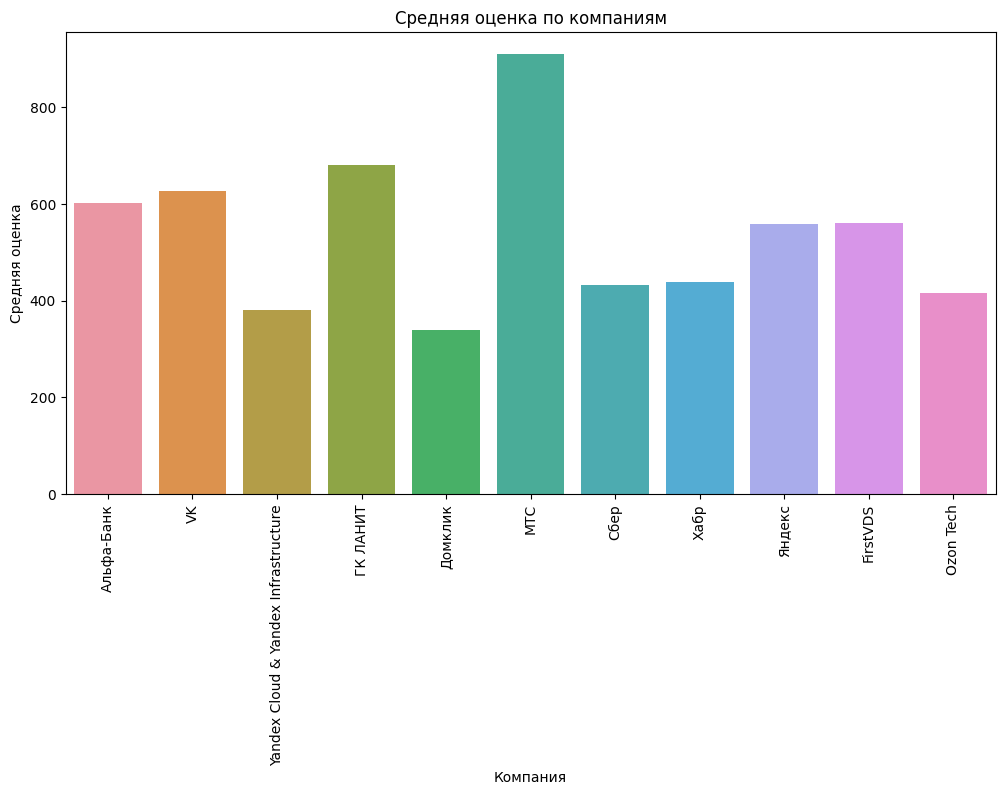

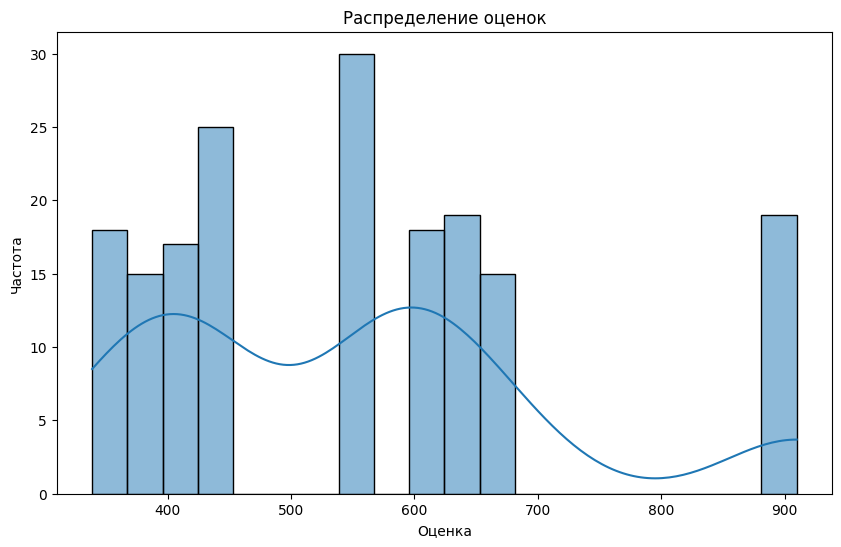

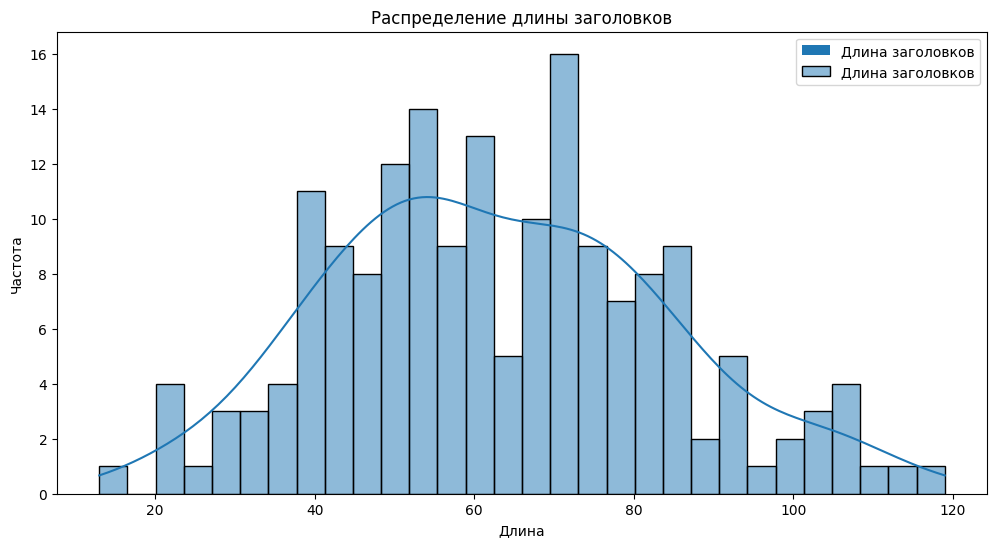

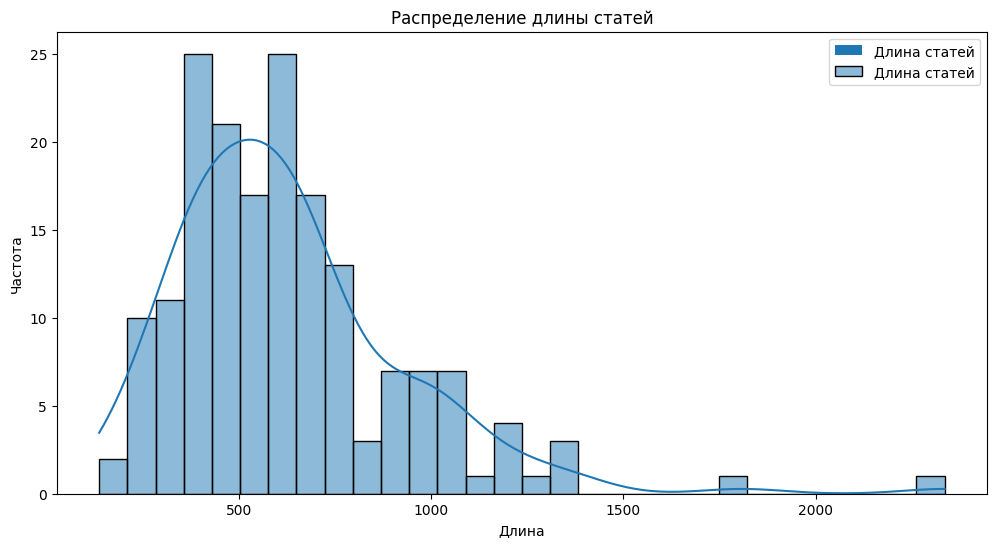

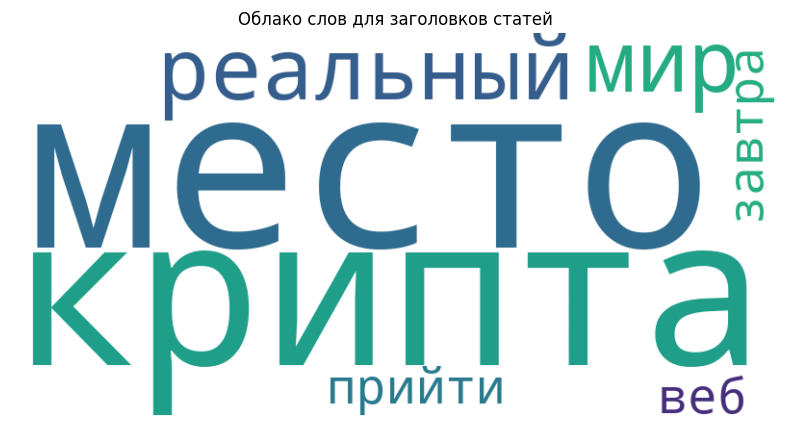

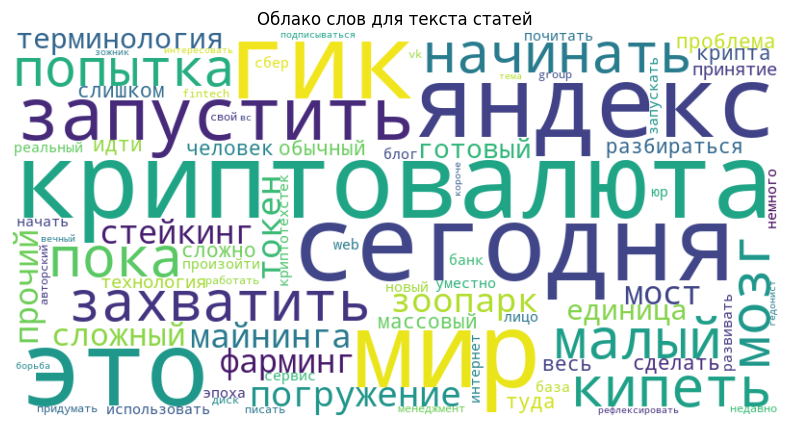

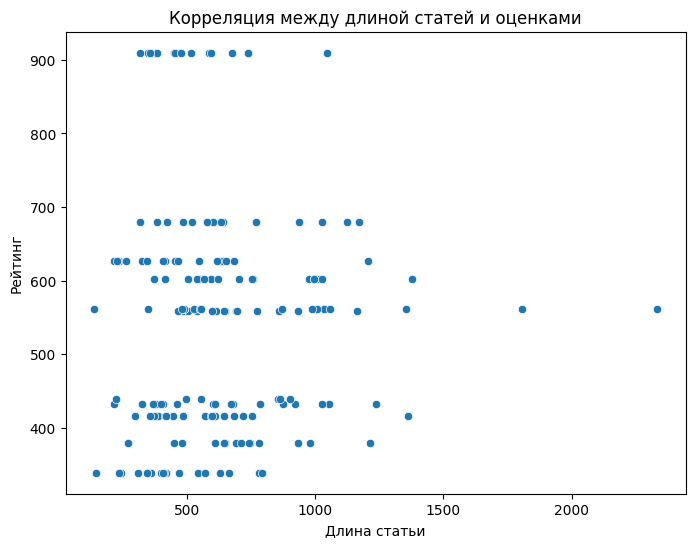

In [165]:
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import numpy as np

# Средняя оценка по компаниям
plt.figure(figsize=(12, 6))
sns.barplot(x='company', y='rating', data=df)
plt.title('Средняя оценка по компаниям')
plt.xlabel('Компания')
plt.ylabel('Средняя оценка')
plt.xticks(rotation=90)
plt.show()

# Распределение оценок
plt.figure(figsize=(10, 6))
sns.histplot(df['rating'], bins=20, kde=True)
plt.title('Распределение оценок')
plt.xlabel('Оценка')
plt.ylabel('Частота')
plt.show()

# Распределение длины статей и заголовков
df['title_length'] = df['titles'].apply(len)
plt.figure(figsize=(12, 6))
sns.histplot(df['title_length'], bins=30, kde=True, label='Длина заголовков')
plt.title('Распределение длины заголовков')
plt.xlabel('Длина')
plt.ylabel('Частота')
plt.legend()
plt.show()

# Распределение длины статей и заголовков
df['article_length'] = df['articles'].apply(len)
plt.figure(figsize=(12, 6))
sns.histplot(df['article_length'], bins=30, kde=True, label='Длина статей')
plt.title('Распределение длины статей')
plt.xlabel('Длина')
plt.ylabel('Частота')
plt.legend()
plt.show()

# Облако слов для статей
wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords = stop_words).generate(' '.join(df['titles_tokens'][0]))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Облако слов для заголовков статей')
plt.show()

# Облако слов для статей
wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords = stop_words).generate(' '.join(df['articles_tokens'][0]))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Облако слов для текста статей')
plt.show()

# Корреляция между длиной статей и оценками
plt.figure(figsize=(8, 6))
sns.scatterplot(x='article_length', y='rating', data=df)
plt.title('Корреляция между длиной статей и оценками')
plt.xlabel('Длина статьи')
plt.ylabel('Рейтинг')
plt.show()


# Вторая сессия

In [ ]:
# # КЛАССИФИКАЦИЯ

# from sklearn.compose import ColumnTransformer
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import StandardScaler
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score, classification_report

# # Разбиение на обучающую и тестовую выборки
# X_train, X_test, y_train, y_test = train_test_split(df[['rating', 'votes', 'views', 'comments', 'titles_processed', 'articles_processed']], df['target'], test_size=0.2, random_state=42)

# # Определение числовых и текстовых признаков
# numeric_features = ['rating', 'votes', 'views', 'comments']
# text_features = ['titles_processed', 'articles_processed']

# # Создание трансформера для числовых признаков
# numeric_transformer = Pipeline(steps=[
#     ('scaler', StandardScaler())
# ])

# # Создание трансформера для текстовых признаков
# text_transformer = Pipeline(steps=[
#     ('tfidf', TfidfVectorizer(max_features=1000))
# ])

# # Объединение трансформеров
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', numeric_transformer, numeric_features),
#         ('text', text_transformer, text_features)
#     ])

# # Создание модели
# model = Pipeline(steps=[('preprocessor', preprocessor),
#                         ('classifier', RandomForestClassifier())])

# # Обучение модели
# model.fit(X_train, y_train)

# # Предсказание на тестовой выборке
# y_pred = model.predict(X_test)

# # Оценка модели
# accuracy = accuracy_score(y_test, y_pred)
# classification_rep = classification_report(y_test, y_pred)

# print(f'Accuracy: {accuracy}')
# print('Classification Report:')
# print(classification_rep)


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import adjusted_rand_score
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt

# Разбиение выборки
X_train, X_test = train_test_split(df, test_size=0.2, random_state=42)

# Обучение моделей
kmeans = KMeans(n_clusters=3)
kmeans.fit(X_train[['votes', 'views', 'comments']])

rf = RandomForestClassifier()
rf.fit(X_train[['votes', 'views', 'comments']], y_train)

lr = LinearRegression()
lr.fit(X_train[['votes', 'views', 'comments']], y_train)

# Кластеризация
clusters = kmeans.predict(X_test[['votes', 'views', 'comments']])

# Оценка качества кластеризации
ari = adjusted_rand_score(y_test, clusters)

# Оптимизация модели
pca = PCA(n_components=2)
rf_optimized = make_pipeline(pca, rf)

# Подбор гиперпараметров
param_grid = {'randomforestclassifier__n_estimators': [10, 50, 100]}
grid = GridSearchCV(rf_optimized, param_grid=param_grid, cv=5)
grid.fit(X_train[['votes', 'views', 'comments']], y_train)

# Оценка качества после оптимизации
optimized_ari = adjusted_rand_score(y_test, grid.predict(X_test[['votes', 'views', 'comments']]))

# Кривые валидации и обучения
train_sizes, train_scores, test_scores = learning_curve(grid, X_train[['votes', 'views', 'comments']], y_train, cv=5)

# Визуализация кривых
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Validation score')
plt.title('Learning curve')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.legend()
plt.show()
